# Linear Regression  on a Combined Cycle Power Plant (CCPP) data
## Dataset description

The dataset contains 5281 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (PE)  of the plant.

A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum has effect on the Steam Turbine, the other three of the ambient variables effect the GT performance.

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

%matplotlib inline

## Import Data

In [85]:
IDnumber = 2091106
np.random.seed(IDnumber)

path = "./combined-cycle-power-plant.csv"

df = pd.read_csv(path, sep=";")

col_names = df.columns
print(col_names)

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')


In [86]:
data = df.values

# A quick overview of data

In [87]:
data_description = stats.describe(data)
print(data_description)

df.info()

DescribeResult(nobs=5281, minmax=(array([  1.81,  25.36, 992.89,  25.56, 420.26]), array([  37.11,   81.56, 1033.29,  100.16,  495.23])), mean=array([  19.67317553,   54.31940163, 1013.22432115,   73.38815187,
        454.31701004]), variance=array([ 56.0327041 , 161.7733201 ,  35.2083789 , 217.43618617,
       291.84459771]), skewness=array([-0.13713412,  0.19522075,  0.24934713, -0.43467097,  0.29846615]), kurtosis=array([-1.04662553, -1.45165813,  0.01128758, -0.43044229, -1.05785395]))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5281 entries, 0 to 5280
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      5281 non-null   float64
 1   V       5281 non-null   float64
 2   AP      5281 non-null   float64
 3   RH      5281 non-null   float64
 4   PE      5281 non-null   float64
dtypes: float64(5)
memory usage: 206.4 KB


# Split data in training, validation and test sets



Given $m$ total data, keep $m_t$ data as training data, $m_{val}:=m_{tv}-m_t$ as validation data and $m_{test}:=m - m_{val} - m_t = m-m_{tv}$ for test data. For instance one can take $m_t=m/3$ of the data as training, $m_{val}=m/3$  validation and $m_{test}=m/3$ as testing. Let us define as define

$\bullet$ $S_{t}$ the training data set

$\bullet$ $S_{val}$ the validation data set

$\bullet$ $S_{test}$ the testing data set


The reason for this splitting is as follows:

TRAINING DATA: The training data are used to compute the training loss
$$
L_S(h) = \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
which is used to estimate $h$ in a given model class ${\cal H}$.
i.e. 
$$
\hat h = {\rm arg\; min}_{h \in {\cal H}} \, L_S(h)
$$

VALIDATION DATA: Validation data are used when different model classes are present (e.g. of different complexity such as linear regression which used a different number $d_j$ of features $x_1$,...$x_{d_j}$ in the model). In general, with more features one can better fit the training set, so one has to choose which one is the "best" complexity. Let ${\cal H}_{d_j}$ be the space of models as a function of the complexity $d_j$ and let 
$$
\hat h_{d_j} = {\rm arg\; min}_{h \in {\cal H}_{d_j}} \, L_S(h)
$$

One can estimate the generalization error for model $\hat h_{d_j}$ as follows:
$$
L_{{\cal D}}(\hat h_{d_j}) \simeq \frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$
and then choose the complexity which achieves the best estimate of the generalization error
$$
\hat d: = {\rm arg\; min}_{d_j} \,\frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$

TESTING DATA: Last, the test data set can be used to estimate the performance of the final estimated model
$\hat h_{\hat d_j}$ using:
$$
L_{{\cal D}}(\hat h_{\hat d_j}) \simeq \frac{1}{m_{test}} \sum_{ z_i \in S_{test}} \ell(\hat h_{\hat d_j},z_i)
$$

In [88]:
num_total_samples = data.shape[0]
print(f'Total number of samples: {num_total_samples}')

size_chunk = int(num_total_samples/3.)

print(f'Size of each chunk of data: {size_chunk}')

np.random.shuffle(data)

training_set, val_set, test_set = data[:size_chunk], data[size_chunk:(2*size_chunk)], data[(2*size_chunk):]

X_training = training_set[:, :4]
Y_training = training_set[:, 4]
print(f'Training data input size: {X_training.shape}')
print(f'Training data output size: {Y_training.shape}')

X_validation = val_set[:, :4]
Y_validation = val_set[:, 4]
print(f'Training data input size: {X_validation.shape}')
print(f'Training data output size: {Y_validation.shape}')

X_test = test_set[:, :4]
Y_test = test_set[:, 4]
print(f'Training data input size: {X_test.shape}')
print(f'Training data output size: {Y_test.shape}')

Total number of samples: 5281
Size of each chunk of data: 1760
Training data input size: (1760, 4)
Training data output size: (1760,)
Training data input size: (1760, 4)
Training data output size: (1760,)
Training data input size: (1761, 4)
Training data output size: (1761,)


# Data Normalization

It is common practice in Statistics and Machine Learning to scale the data (= each variable) so that it is centered (zero mean) and has standard deviation equal to $1$. This helps in terms of numerical stability (conditioning) of the (inverse) problems of estimating the ERM model (the coefficients of the linear regression in this case), as well as to give the same scale to all the coefficients. 

In [89]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_training)
X_training = scaler.transform(X_training)

print(f'Mean of the training input data: {X_training.mean(axis=0)}')
print(f'Std of the training input data: {X_training.std(axis=0)}')

X_validation = scaler.transform(X_validation)
print(f'Mean of the training input data: {X_validation.mean(axis=0)}')
print(f'Std of the training input data: {X_validation.std(axis=0)}')

X_test = scaler.transform(X_test)

print(f'Mean of the training input data: {X_test.mean(axis=0)}')
print(f'Std of the training input data: {X_test.std(axis=0)}')

Mean of the training input data: [-7.67063181e-17 -1.04966541e-16 -4.64174154e-15  4.30968392e-16]
Std of the training input data: [1. 1. 1. 1.]
Mean of the training input data: [ 0.01711716  0.00915474 -0.00770901  0.00164919]
Std of the training input data: [0.99743323 0.99856589 1.01464814 1.01445899]
Mean of the training input data: [-0.03642623 -0.0314798   0.02590048 -0.00899686]
Std of the training input data: [1.00962248 1.00059311 1.03018948 0.99998677]


# Model Training 

The model is trained (= estimated) minimizing the empirical error
$$
L_S(h) := \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
where $z_i = (x_i,y_i)$.
When the loss function is the quadratic loss
$$
\ell(h,z) := (y - h(x))^2
$$
we define  the Residual Sum of Squares (RSS) as
$$
RSS(h):= \sum_{z_i \in S_{t}} \ell(h,z_i) = \sum_{z_i \in S_{t}} (y_i - h(x_i))^2
$$ so that the training error becomes
$$
L_S(h) = \frac{RSS(h)}{m_t}
$$

We recall that, for linear models we have $h(x) = <w,x>$ and the Empirical error $L_S(h)$ can be written
in terms of the vector of parameters $w$ in the form
$$
L_S(w) = \frac{1}{m_t}(y - Xw)^T(y-Xw) =  \frac{1}{m_t} \|y - X w\|^2
$$
where $y$ is the vector whose $i-th$ element is the output datum $y_i$ and $X$ is the matrix whose $i-$th row is the input vector $x_i^\top$.

The least squares solution is given by the expression
$$
\hat w = {\rm arg\;min}_w L_S(w) = (X^\top X)^{-1} X^\top Y
$$
When the matrix $X$ is not invertible, the solution can be computed using the Moore-Penrose pseudonymous $(X^\top X)^{\dagger}$ of $(X^\top X)$
$$
\hat w = (X^\top X)^{\dagger} X^\top Y
$$


 In practice some singular values may be very small (e.g. $<1e-12$). Therefore it makes sense to
 first approximate the matrix $A$ truncating the SVD and then using the pseudo-inverse formula.
 
 More specifically, let us postulate that, given a threshold $T_h$ (e.g $=1e-12$), we have $\sigma_i<T_h$, for $i=\hat r + 1,..,r$. Then we can approximate (by SVD truncation) $A$ using:
 
 $$A = USV^\top =U \,{\rm diag}\{s_1,s_2,..,s_r\}\, V^\top \simeq \hat A_r = U\,{\rm diag}\{s_1,s_2,..,s_{\hat r}, 0,..,0\}\,V^\top
 $$
 So that 
 $$
 A^\dagger \simeq \hat A_r^\dagger:= V \,{\rm diag}\{1/s_1,1/s_2,..,1/s_{\hat r}, 0,..,0\}\, U^\top
 $$
 
 The linear regression coefficients can be computed directly using the numpy.linalg.lstsq function

In [90]:
m_training = training_set.shape[0]
X_training = np.hstack((np.ones((m_training,1)),X_training))

m_validation = training_set.shape[0]
X_validation = np.hstack((np.ones((m_validation,1)),X_validation))

m_test = test_set.shape[0]
X_test = np.hstack((np.ones((m_test,1)),X_test))

w_np, RSS_tr_np, rank_X_tr, sv_X_tr = np.linalg.lstsq(X_training, Y_training, rcond=None)

print(f"LR coefficients with numpy lstsq: {w_np}")

print(f"RSS with numpy lstsq: {RSS_tr_np}")
print(f"Empirical risk with numpy lstsq: {RSS_tr_np / m_training}")

LR coefficients with numpy lstsq: [ 4.54274705e+02 -1.45612086e+01 -3.15585834e+00  3.94406488e-01
 -2.43542008e+00]
RSS with numpy lstsq: [37114.77586113]
Empirical risk with numpy lstsq: [21.08794083]


## Data prediction 

Compute the output predictions on both training and validation set and compute the Residual Sum of Squares (RSS) defined above, and the Empirical Loss. Compute also the quantity $R^2$ where
$$
R^2 = 1 - \frac{\sum_{z_i \in S_t} (\hat y_i - y_i)^2}{\sum_{z_i \in S_t} (y_i - \bar y)^2} \quad \quad \bar y = \frac{1}{m_t} \sum_{z_i \in S_t} y_i
$$
is the so-called "Coefficient of determination" (COD)

In [91]:
def compute_cost_linear_regression(y, y_hat):
    err = np.subtract(y, y_hat) ** 2
    cost = np.sum(err)

    return cost


def compute_R_measure(y, y_hat):
    me = np.mean(y)
    return 1 - (np.sum((y_hat - y)**2) / np.sum((y - me)**2))

def linear_regression(X, w):
    return np.dot(X, w)

In [92]:
prediction_training = linear_regression(X_training, w_np)
prediction_validation = linear_regression(X_validation, w_np)
prediction_test = linear_regression(X_test, w_np)

RSS_validation = compute_cost_linear_regression(Y_validation, prediction_validation)
RSS_test = compute_cost_linear_regression(Y_test, prediction_test)

print(f'RSS on validation data: {RSS_validation}')
print(f'Loss estimated from validation data: {RSS_validation / m_validation}')


print(f'RSS on test data: {RSS_test}')
print(f'Loss estimated from test data: {RSS_test/m_test}')

R_measure_training = compute_R_measure(Y_training, prediction_training)
R_measure_validation = compute_R_measure(Y_validation, prediction_validation)
R_measure_test = compute_R_measure(Y_test, prediction_test)

print(f'Measure on Training Data (1-R^2): {R_measure_training}')
print(f'Measure on Validation Data(1-R^2): {R_measure_validation}')
print(f'Measure on Test Data(1-R^2): {R_measure_validation}')

RSS on validation data: 37894.20662590026
Loss estimated from validation data: 21.53079921926151
RSS on test data: 35630.823218141755
Loss estimated from test data: 20.233289732050967
Measure on Training Data (1-R^2): 0.9270939077650432
Measure on Validation Data(1-R^2): 0.9261573526543415
Measure on Test Data(1-R^2): 0.9261573526543415


## ... and plot:


### (1) output predictions on training  data

Note that in the following plot and in the analogous plots below the data is permuted so that the predictions are increasing with the index of the instance in the plot.

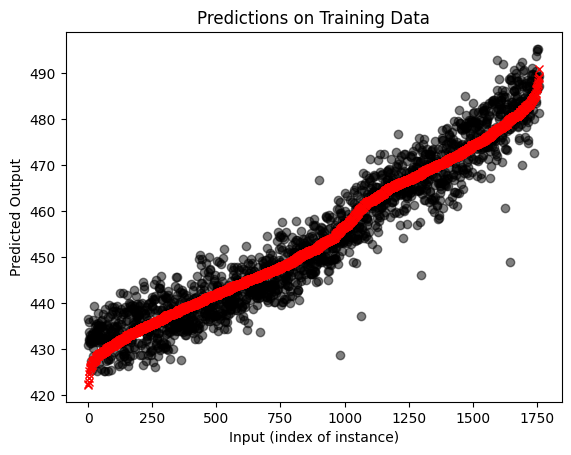

In [93]:
plt.figure()

sorting_permutation = sorted(range(len(prediction_training[0:m_training])), key=lambda k: prediction_training[0:m_training][k])
plt.plot(Y_training[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_training[sorting_permutation], 'rx')

plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Training Data')
plt.show()

### (2) output predictions on validation  data

Plot predictions on validation data.

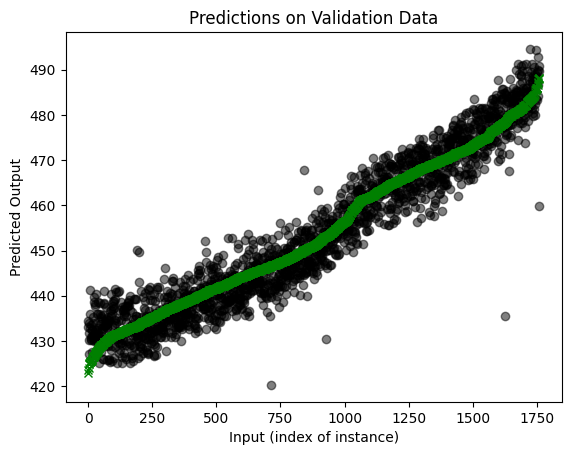

In [94]:
plt.figure()

sorting_permutation = sorted(range(len(prediction_validation[0:m_validation])), key=lambda k: prediction_validation[0:m_validation][k])
plt.plot(Y_validation[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_validation[sorting_permutation], 'gx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Validation Data')
plt.show()

# Removing some features

Perform same as above removing 1 feature that you think may not be as important as the other ones for prediction; recall that, since the data has been normalized, may be done by looking at the weights of each feature in the learned model.

In [95]:
print(f"Coefficients of the trained model: {w_np}")

Coefficients of the trained model: [ 4.54274705e+02 -1.45612086e+01 -3.15585834e+00  3.94406488e-01
 -2.43542008e+00]


In [96]:
selected_features = ['AT', 'V', 'AP']
X_training_reduced = np.delete(X_training, axis=1, obj=3)
X_validation_reduced = np.delete(X_validation, axis=1,obj=3)
X_test_reduced = np.delete(X_test, axis=1, obj=3)

w_np_reduced, RSS_tr_np_reduced, rank_Xtr_reduced, sv_Xtr_reduced = np.linalg.lstsq(X_training_reduced, Y_training, rcond=None)

print(f"LR coefficients of reduced model: {w_np_reduced}")

prediction_training_reduced = linear_regression(X_training_reduced, w_np_reduced)
prediction_validation_reduced = linear_regression(X_validation_reduced, w_np_reduced)
prediction_test_reduced = linear_regression(X_test_reduced, w_np_reduced)

RSS_training_reduced = compute_cost_linear_regression(Y_training, prediction_training_reduced)

print(f'RSS on training data of reduced model: {RSS_training_reduced}')
print(f"Loss estimated from training data of reduced model: {RSS_training_reduced/m_training}")

RSS_validation_reduced = compute_cost_linear_regression(Y_validation, prediction_validation_reduced)

print(f"RSS on validation data of reduced model: {RSS_validation_reduced}")
print(f"Loss estimated from validation data of reduced model: {RSS_validation_reduced/m_validation}")

RSS_test_reduced = compute_cost_linear_regression(Y_test, prediction_test_reduced)

print(f"RSS on test data of reduced model: {RSS_test_reduced}")
print(f"Loss estimated from test data of reduced model: {RSS_test_reduced / m_test}")

R_measure_training = compute_R_measure(Y_training, prediction_training_reduced)
print(f"Measure on training data of reduced model: {R_measure_training}")
R_measure_validation = compute_R_measure(Y_validation, prediction_validation_reduced)
print(f"Measure on validation data of reduced model: {R_measure_validation}")
R_measure_test = compute_R_measure(Y_test, prediction_test_reduced)
print(f"Measure on test data of reduced model: {R_measure_test}")

LR coefficients of reduced model: [454.27470455 -14.89005629  -3.08153737  -2.54553498]
RSS on training data of reduced model: 37301.08170756415
Loss estimated from training data of reduced model: 21.19379642475236
RSS on validation data of reduced model: 37988.62190296412
Loss estimated from validation data of reduced model: 21.584444263047796
RSS on test data of reduced model: 35731.047030760215
Loss estimated from test data of reduced model: 20.29020274319149
Measure on training data of reduced model: 0.926727939470502
Measure on validation data of reduced model: 0.9259733700715395
Measure on test data of reduced model: 0.9310286066592731


## Plot prediction on validation data for the reduced model

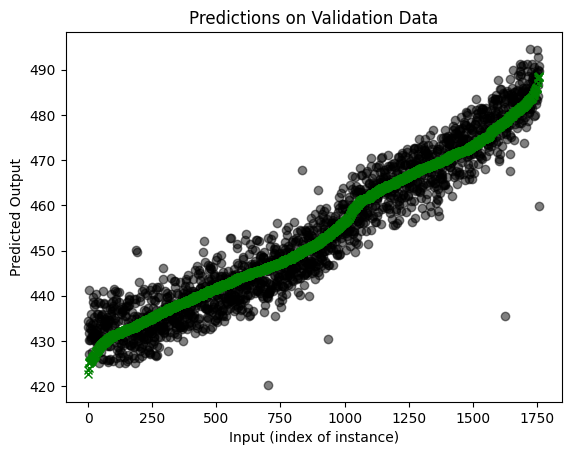

In [97]:
plt.figure()

sorting_permutation = sorted(range(len(prediction_validation_reduced[0:m_validation])), key=lambda k: prediction_validation_reduced[0:m_validation][k])
plt.plot(Y_validation[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_validation_reduced[sorting_permutation], 'gx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Validation Data')
plt.show()

# MODEL SELECTION 

**TO DO**: Based on the results of the estimated models (full model and reduced model) **on the validation data** which one would you choose? Explain the choice. Is this choice supported by the predictions of the estimated models **on the test data**? Explain your reasoning.

**ANSWER**
Since the models result in close precision (the RSS and R Measure are close), I would choose the model with less features, the reduced model, since it is simpler and the more number of features increases the possibility of overfitting. (At least as far as I know:) )

## Ordinary Least-Squares using scikit-learn

A fast way to compute the LS estimate is through sklearn.linear_model

In [98]:
X_training = X_training[:,1:]
X_test = X_test[:,1:]

In [99]:
from sklearn import linear_model

lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_training, Y_training)
print("Intercept:", lin_reg.intercept_)
print("Least-Squares Coefficients:", lin_reg.coef_)
prediction_training = lin_reg.predict(X_training)
prediction_test = lin_reg.predict(X_test)
print("Measure on training data:", 1-lin_reg.score(X_training, Y_training))

Intercept: 454.2747045454546
Least-Squares Coefficients: [-14.5612086   -3.15585834   0.39440649  -2.43542008]
Measure on training data: 0.07290609223495681
